# Getting Started
Mount your drive and import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import

from PIL import Image
from tqdm import tqdm
from skimage import color, io
from skimage.color import lab2rgb, rgb2gray

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from skimage.io import imsave
from keras.models import Sequential

import tensorflow as tf
import numpy as np
import pickle
import random

import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Preprocess Data
Run next code block to preprocess data. Remember to download the Flickr 8K dataset from Kaggle and change the paths accordingly: https://www.kaggle.com/datasets/adityajn105/flickr8k

In [ ]:
def process_images(image_names, data_folder):
    train_images = []
    train_labels = []
    
    # Create a progress bar for iterating over a list of image_names
    pbar = tqdm(image_names)
 
    # Set the description of the current progress bar
    # Example: [1/1] Processing 'data/Images/10815824_2997e03d76.jpg': 100%
    for i, image_name in enumerate(pbar):
        img = f'{data_folder}/Images/{image_name}'
        
        # The Image class in the Pillow library is used to open images as an np array. 3 means RGB.
        with Image.open(img) as img: # print("img shape:", np.shape(img)): (333, 500, 3)
            img_array = np.array(img.resize((256,256))) # print("img_array shape", np.shape(img_array)): (256, 256, 3)
            
        # Convert RGB to LAB
        img_lab_rs = color.rgb2lab(1.0/255*img_array) # Shape: (256, 256, 3)
        
        # Extract Lightness from LAB and convert to tensor 
        img_l_rs = img_lab_rs[:,:,0]
        img_l_rs = img_l_rs.reshape((256, 256, 1))
        # tens_rs_l = tf.convert_to_tensor(img_l_rs) # tens_rs_l tf.Tensor([256 256], shape=(2,), dtype=int32)

        # Extract A and B from LAB and convert to tensor 
        img_ab_rs = img_lab_rs[:,:,1:]
        img_ab_rs /= 128
        # tens_rs_ab = tf.convert_to_tensor(img_ab_rs) # tens_rs_ab tf.Tensor([256 256 2], shape=(3,), dtype=int32)
        
        train_images += [img_l_rs]
        train_labels += [img_ab_rs]

    return train_images, train_labels

def load_data(data_folder, batch):
    train_images = []
    train_labels = []

    # all_pics = io.ImageCollection(f'{data_folder}/Images/*.jpg', load_func=load_imgs)

    text_file_path = f'{data_folder}/captions.txt'
    with open(text_file_path) as file:
        examples = file.read().splitlines()[1:]

    image_names_to_captions = {}

    for example in examples:
        img_name, caption = example.split(',', 1)
        image_names_to_captions[img_name] = image_names_to_captions.get(img_name, []) + [caption]

    # shuffle images
    shuffled_images = list(image_names_to_captions.keys())
    random.seed(0)
    random.shuffle(shuffled_images)

    # adjust splicing to change batch sizes
    if batch == 'train1':
        data = shuffled_images[1000:3500]
    elif batch == 'train2':
        data = shuffled_images[3500:6000]
    elif batch == 'train3':
        data = shuffled_images[6000:]
    else:
        data = shuffled_images[:1000]

    images, labels = process_images(data, data_folder)

    create_pickle(np.array(images), data_folder + batch)
    create_pickle(np.array(labels), data_folder + batch + '_labels')

def create_pickle(data, file):
    with open(f'/{file}.p', 'wb') as pickle_file:
        pickle.dump(data, pickle_file)
    print(f'Data has been dumped into {file}.p!')


if __name__ == '__main__':
    ## Download this and put the Images into your ../data directory
    ## Flickr 8k Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

    path = '/content/drive/MyDrive/Colab Notebooks/data/'
    
    load_data(path, 'train1')
    # load_data(path, 'train2')
    # load_data(path, 'train3')
    # load_data(path, 'test')

100%|██████████| 2500/2500 [10:25<00:00,  4.00it/s]


Data has been dumped into /content/drive/MyDrive/Colab Notebooks/data/train2.p!
Data has been dumped into /content/drive/MyDrive/Colab Notebooks/data/train2_labels.p!


100%|██████████| 2091/2091 [08:05<00:00,  4.31it/s]


Data has been dumped into /content/drive/MyDrive/Colab Notebooks/data/train3.p!
Data has been dumped into /content/drive/MyDrive/Colab Notebooks/data/train3_labels.p!


100%|██████████| 1000/1000 [03:51<00:00,  4.32it/s]


Data has been dumped into /content/drive/MyDrive/Colab Notebooks/data/test.p!
Data has been dumped into /content/drive/MyDrive/Colab Notebooks/data/test_labels.p!


# Model
The code block below contains our model. We need to update the architecture and determine which batch size and epochs work best.

## Basic model

In [ ]:
def make_basic_model(model):
    model.add(InputLayer(input_shape=(None, None, 1)))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.compile(optimizer='adam', loss='mse')

## Paper model
Next is the model as described in the paper

In [ ]:
from tensorflow.keras.layers import Normalization

def make_paper_model(model):
    model.add(InputLayer(input_shape=(None, None, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Normalization())

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Normalization())

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Normalization())

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Normalization())

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Normalization())

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Normalization())

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Normalization())

    model.add(Conv2DTranspose(256, (4, 4), activation='relu', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(313, (3, 3), activation='softmax', padding='same'))


    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    # model.add(UpSampling2D((2, 2)))
    # model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(tf.keras.layers.Reshape((256, 256)))
    model.compile(optimizer='adam', loss='mse')

In [ ]:
from tensorflow.python import train

def load_data(file):
    with open(f'/{file}.p', 'rb') as data_file:
        data = pickle.load(data_file)
    return data

def main():
    model = Sequential()
    make_basic_model(model)
    # make_paper_model(model)

    path = '/content/drive/MyDrive/Colab Notebooks/data'
    
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = path + "/checkpoints/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    batch_size = 64

    for i in range(1, 2):
        images = load_data(f'{path}/train{i}')
        labels = load_data(f'{path}/train{i}_labels')
        images = images[:]
        labels = labels[:164]
        test = images[:100]
        test_labels = labels[:100]
        images = images[100:]
        labels = labels[100:]

        history = model.fit(x=images, y=labels, batch_size=batch_size, epochs=500)

    output = model.predict(test)
    output *= 128

    with open(path + '/trainHistoryDict', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

    # Output colorizations
    for i in range(1, 6):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = test[i][:,:,0]
        cur[:,:,1:] = output[i][:,:,:]

        cur_gray = rgb2gray(lab2rgb(cur))
        cur = lab2rgb(cur)

        im = (255*cur).astype(np.uint8)
        imgray = (255*cur_gray).astype(np.uint8)
        imsave(f"{path}/DL_images/img_result{i}.png", im)
        # imsave(f"{path}/DL_images/img_gray_version{i}.png", imgray)
    return

if __name__ == '__main__':
    main()

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 0.9386
Epoch 2/500
1/1 [==============================] - 0s 177ms/step - loss: 0.5051
Epoch 3/500
1/1 [==============================] - 0s 132ms/step - loss: 0.5116
Epoch 4/500
1/1 [==============================] - 0s 132ms/step - loss: 0.5122
Epoch 5/500
1/1 [==============================] - 0s 130ms/step - loss: 0.5616
Epoch 6/500
1/1 [==============================] - 0s 138ms/step - loss: 0.4707
Epoch 7/500
1/1 [==============================] - 0s 136ms/step - loss: 0.4972
Epoch 8/500
1/1 [==============================] - 0s 132ms/step - loss: 0.4379
Epoch 9/500
1/1 [==============================] - 0s 139ms/step - loss: 0.4288
Epoch 10/500
1/1 [==============================] - 0s 138ms/step - loss: 0.3927
Epoch 11/500
1/1 [==============================] - 0s 135ms/step - loss: 0.3088
Epoch 12/500
1/1 [==============================] - 0s 131ms/step - loss: 0.1328
Epoch 13/500
1/1 [======================

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)


Run the cell below to plot the loss of the model!

dict_keys(['loss'])


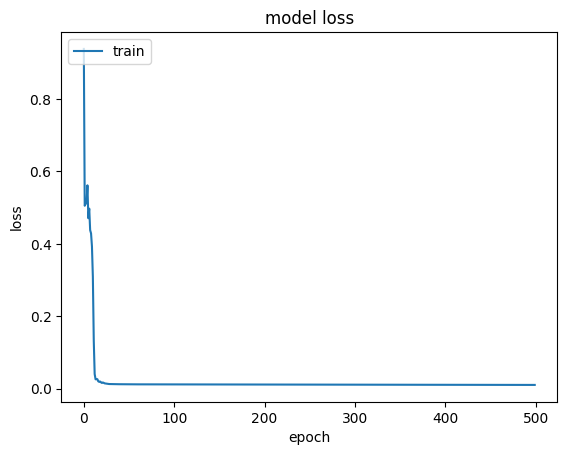

In [ ]:
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Colab Notebooks/data'

with open(path + '/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

print(history.keys())

plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()